# Module 4 Project
Name: Rachel Spiro <br>
Instructor: Jeff Herman <br>
Course: Self-Paced Data Science

For this project, I will be analyzing housing data from Zillow in order to help a real-estate investment firm determine what are the best 5 zipcodes to invest in. I will be forecasting future average home prices in each region to get an understanding of the potential growth each region could have. 

# Step 1: Load the Data/Filtering for Chosen Zipcodes

I will first import all necessary libraries along with the data file so that we have everything needed to begin the analysis.

In [1]:
# Import necessary libraries
# Libraries for data exploration
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import statsmodels as sm

# Libraries for data visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib.lines import Line2D
import matplotlib.font_manager
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

# Libraries for modeling
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
from statsmodels.tsa.stattools import adfuller


# Save models
import pickle

In [2]:
# Read in the data file
data = pd.read_csv('zillow_data.csv')
# Show first 5 rows to get a sense of what data we are working with
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Data Preprocessing

To begin, I will preprocess the data to make sure everything is in a format that our model will be able to use. The first step I will take is changing the dates within each column label to the needed datetime format.

In [3]:
# Convert columns containing dates to datetime
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')
data.columns = list(data.columns[:7]) + list(get_datetimes(data))
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Next I will see if we have any null values. Our model will not work if we have null values, so if we do have any, they will either need to be replaced with other data or removed from the dataset. Let's first look at the categorical columns, and then follow up with the columns representing home prices.

In [4]:
# Check if we have any null values in our first 7 categorical columns
data.iloc[:,0:7].isnull().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
dtype: int64

It looks like the metro column has 1000+ null values. We will need to replace those in order for our data to be run correctly in our model. Since this is a categorical column, I will replace all of these null values with 'Not Applicable'

In [5]:
# Replace null values and double check our code worked
data['Metro'].fillna('Not Applicable', inplace=True)
data.iloc[:,0:7].isnull().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
dtype: int64

Now I will look at all of the date columns to see if we have any null values there.

In [6]:
data.iloc[:,7:].isnull().sum()

1996-04-01    1039
1996-05-01    1039
1996-06-01    1039
1996-07-01    1039
1996-08-01    1039
1996-09-01    1039
1996-10-01    1039
1996-11-01    1039
1996-12-01    1039
1997-01-01    1039
1997-02-01    1039
1997-03-01    1039
1997-04-01    1039
1997-05-01    1039
1997-06-01    1039
1997-07-01    1038
1997-08-01    1038
1997-09-01    1038
1997-10-01    1038
1997-11-01    1038
1997-12-01    1038
1998-01-01    1036
1998-02-01    1036
1998-03-01    1036
1998-04-01    1036
1998-05-01    1036
1998-06-01    1036
1998-07-01    1036
1998-08-01    1036
1998-09-01    1036
              ... 
2015-11-01       0
2015-12-01       0
2016-01-01       0
2016-02-01       0
2016-03-01       0
2016-04-01       0
2016-05-01       0
2016-06-01       0
2016-07-01       0
2016-08-01       0
2016-09-01       0
2016-10-01       0
2016-11-01       0
2016-12-01       0
2017-01-01       0
2017-02-01       0
2017-03-01       0
2017-04-01       0
2017-05-01       0
2017-06-01       0
2017-07-01       0
2017-08-01  

It looks like we do have some null values. Later on I will be modelling only based on data from 2012-2018, so I want to make sure I have complete data within that time frame. Therefore, I will drop any rows that do not have full data from April 2012-April 2018 (April is the most recent month we have and I want to work with full years which is why I am starting my timeframe with April as well).

In [7]:
# Remove any rows with null values from April 2012 onwards (this starts in column 199 of the dataset) 
data.dropna(inplace=True, subset=list(data.columns[199:]))

# Step 3: EDA and Visualization

Now that our data has been preprocessed, I will start to do some exploratory data analysis and create some visualizations to better understand the data. First, I will set some parameters for how I want the visualizations to look, I will then setup some functions that I will use to visualize some of the data in a map format.

In [8]:
# Set default chart visuals:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

plt.gcf().autofmt_xdate()

# Gradient color lists to be used in some charts:
colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]

colorscale2 = ['#E0F2F1','#B2DFDB','#a0d8d3','#7cc9c2','#80CBC4','#4DB6AC','#26A69A',
               '#009688','#00897B','#00796B','#00695C','#004D40']

# List of colors to be used in some charts:
color_list = ['magenta','yellow','blue','green','red']

<Figure size 432x288 with 0 Axes>

It will be helpful to visualize some of the data we are investigating on a map, so I will import state data in order to be able to properly map our data.

In [9]:
# Read in states file:
states_data = gpd.read_file("./States/states.shp")
# Look at data we just pulled in:
states_data.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...


To make our states data easier to work with, I will put the data in alphabetical order by state abbreviation and will set the state abbreviation column as the index.

In [10]:
# Put the states in alphabetical order and set index:
states_data = states_data.sort_values('STATE_ABBR')
states_data.set_index('STATE_ABBR', inplace=True)
states_data.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,geometry
STATE_ABBR,,,,,
AK,Alaska,51,02,Pacific,(POLYGON ((-161.3337853466416 58.7332483821643...
AL,Alabama,43,01,East South Central,POLYGON ((-85.07006727561546 31.98070335724909...
AR,Arkansas,47,05,West South Central,POLYGON ((-94.46169128436209 34.19676535931296...
AZ,Arizona,37,04,Mountain,POLYGON ((-114.5206273030434 33.02770735822419...
CA,California,25,06,Pacific,(POLYGON ((-121.6652203096974 38.1692853630126...


Now that we have the state data imported, I will create a function to color the map with a gradient color scheme and will create another function to generate the maps I want. When these functions are used, I will be able to create a map that is color coded based on a specified metric. For example, I can create a map where states with a greater number of zip codes are darker colored and states with fewer zip codes will be a lighter color.

In [11]:
def gradient_mapper(metric,grad):
    
    '''
    This function outputs a list of colors that corresponds to each item in a list/series of numbers.
    This will be used to color our state map heatmap.
    
    Parameters:
    - metric - the data that we are transforming into colors
    - grad - list of colors that the metric data will be transformed to
    
    '''
    # Define the minimum and the maximum points in the dataset
    metric_min = metric.min()
    metric_max = metric.max()

    # Calculate how many colors we have in the given gradient color scheme
    colors = len(grad)-1
    
    # Transform the data to integers between zero and the length of the gradient list
    first_map = list(map(lambda x: int(round(colors*(x-metric_min) / (metric_max-metric_min),0)), list(metric)))
    
    # Map the integers to the gradient list, which is what will be used to color the state heatmaps
    return list(map(lambda x: grad[x], first_map))



def state_map(metric, grad, title, states = list(states_data.index), annot=True,
              pacific=True, dc=True, size=30, cb=True):
    
    '''
    Create a map of the states that has a color gradient based on a given metric for each state.
    
    Parameters:
    - metric - Column data we will use to identify the coloring of the map. 
            The column must be from the states_data dataframe.
    - grad - The color scheme we will use to color our map.
    - title - Title for the chart
    - states - List of state that we want to map (based on state abbreviations).
    - annot - If true this will write state names and corresponding metric values on the map. 
                If false no labels will be displayed.
    - pacific - Will include the pacific states (Hawaii and Alaska) in the bottom left corner of the chart if true.
    - size - Set the plot width (height will auto-adjust).
    - cb - If true will include a color bar as a key.
    
    '''
   
    # Create a temporary dataframe that contains the state abbreviations as an index 
    # and the geometry of each state with corresponding metric values:
    data_temp = states_data.loc[states,['geometry',metric]]
    
    # Drop states that have null values:
    data_temp = data_temp.dropna()
    
    # Create local varaibles for pacific and mainland states:
    pacific_states = ['AK','HI']
    mainland_states = list(filter(lambda x: x not in pacific_states,
                              list(data_temp.index)))
    
    # If no values for DC or pacific states, remove from our temporary dataframe:
    if dc == False and dc in states:
        data_temp = data_temp.drop('DC')
        mainland_states.remove('DC')
        
    if pacific == False and 'HI' in states and 'AK' in states:
        data_temp = data_temp.drop(['HI','AK'])
    
    # Use the gradient_mapper function to add the color gradient based on metric values:
    data_temp['Colors'] = gradient_mapper(metric=data_temp[metric],grad=grad)
        
    # Create a figure and axes for our chart:
    fig, ax = plt.subplots(figsize=(size,size/2))
    plt.title(title, fontsize=30)
    
    
    # First, plot the mainland states 
    for i in mainland_states:
        data_temp.loc[[i]].plot(ax=ax, color=data_temp.loc[i,'Colors'])
                
        # Indicate necessary data for if we are annotating:
        if annot == True:
            
            # Locate the location we want to plot text (the center of each state):
            centroid = data_temp.loc[[i]].centroid
            
            # Plot the text in this location:
            plt.annotate(s=f'{round(data_temp.loc[i,metric],1)}',
                 xy=(centroid.x[i], centroid.y[i]),
                 horizontalalignment='center',
                 color='white',
                 fontsize=size/2)
            
    # Remove axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Second, plot the Pacific states in their own separate subplots
    if pacific == True:
        if 'AK' in states:
            ax2 = fig.add_subplot(3,6,13)
            states_data.loc[['AK']].plot(ax=ax2,
                                       color=data_temp.loc['AK','Colors'])
            ax2.patch.set_alpha(0)
            ax2.set_xticks([])
            ax2.set_yticks([])
        
        if 'HI' in states:
            ax3 = fig.add_subplot(3,6,14)
            states_data.loc[['HI']].plot(ax=ax3,
                                       color=data_temp.loc['HI','Colors'])
            ax3.patch.set_alpha(0)
            ax3.set_xticks([])
            ax3.set_yticks([])
        
    # Third, plot the colorbar key
    if cb == True:        
        cmap = LinearSegmentedColormap.from_list(name= '', colors=grad, N=50)
        ax4 = fig.add_subplot(1,30,30)
        norm = mpl.colors.Normalize(vmin=data_temp[metric].min(),
                                    vmax=data_temp[metric].max())
        cb = mpl.colorbar.ColorbarBase(ax4, cmap=cmap,
                                       norm=norm, orientation='vertical')
           
    sns.despine(left=True,bottom=True)

Let's take a look at which states have the most vs. least number of zipcodes.

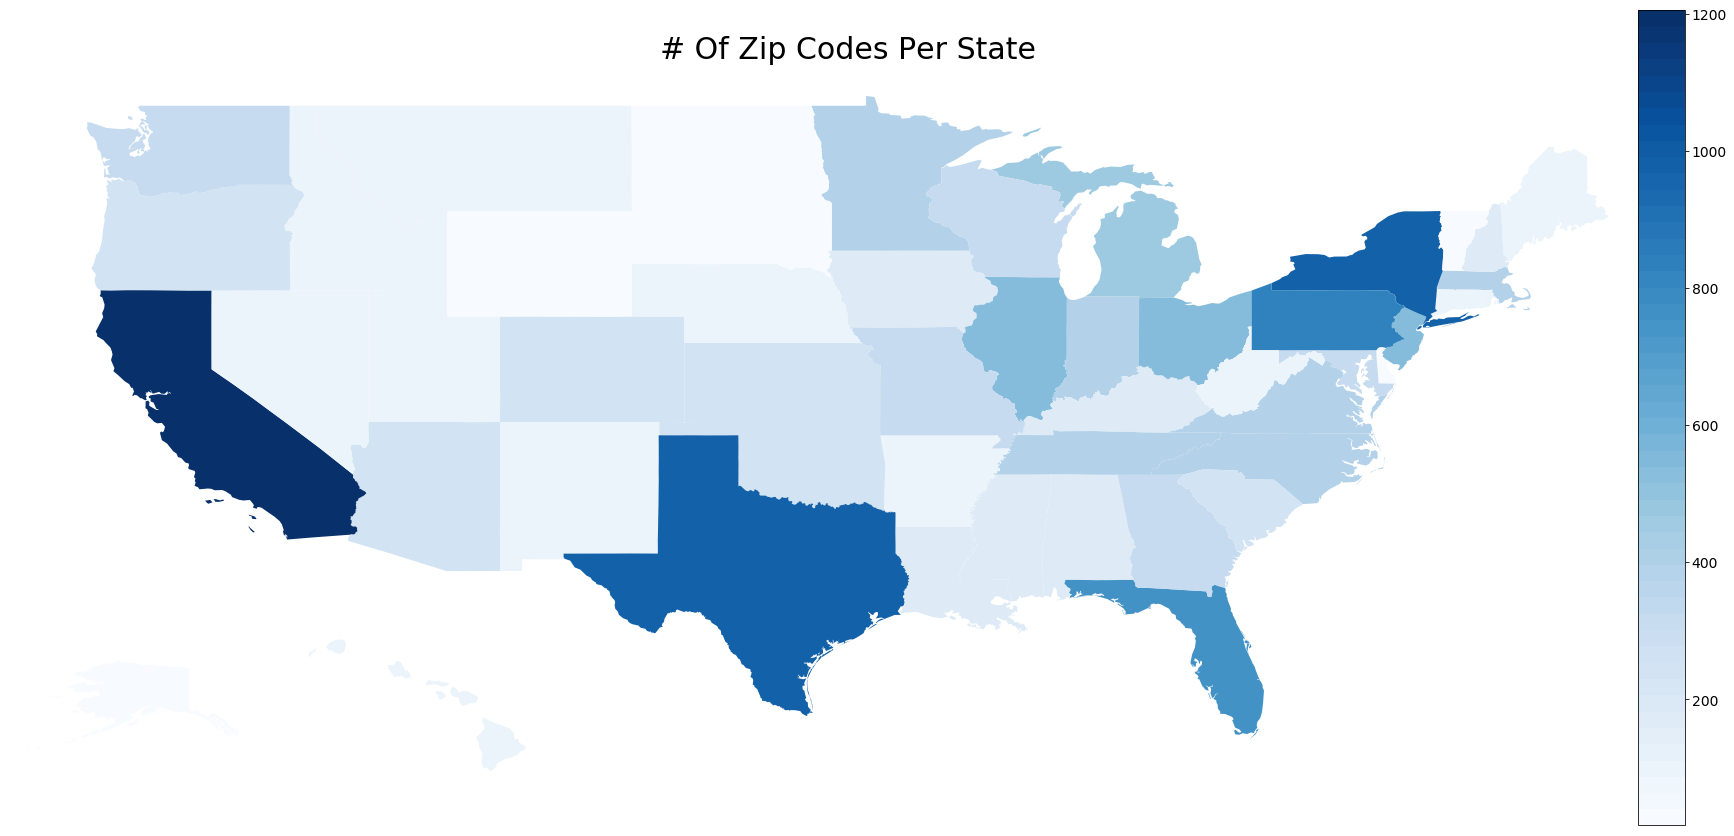

In [12]:
# Count number of zip codes (regions) in each state:
states_data['RegionCount'] = data.groupby('State').count()['RegionName']

# Map this data:
state_map(metric = 'RegionCount', title = '# Of Zip Codes Per State', grad = colorscale, annot=False, pacific=True)

As expected, it looks like the states with larger populations, such as California, Texas, New York, Florida, and Pennsylvania have the most zip codes present.

Now lets see the breakdown of states based on average house prices in the most recent data we have from April 2018. I will look at both the median and the mean to see how these average metrics vary.

In [13]:
# Pull the median and mean house price values by state from April 2018:
states_data['April_2018_median'] = data.groupby(
    'State').median()[pd.to_datetime('2018-04', format='%Y-%m')]

states_data['April_2018_mean'] = data.groupby(
    'State').mean()[pd.to_datetime('2018-04', format='%Y-%m')]

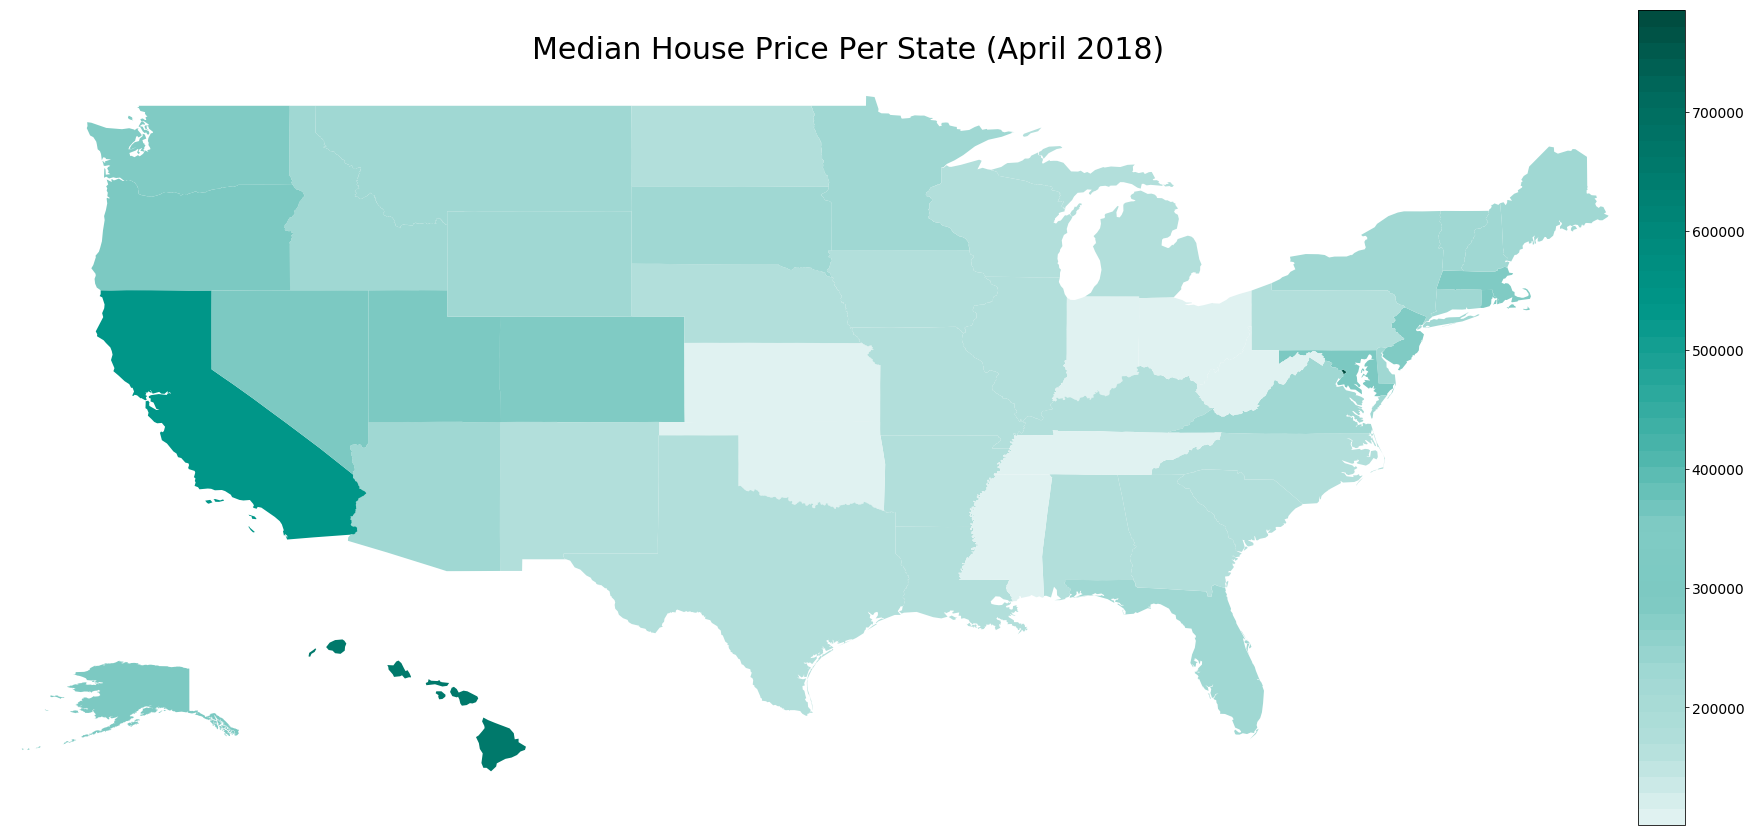

In [14]:
# Look at the median on a state by state basis:
state_map(metric = 'April_2018_median', title = 'Median House Price Per State (April 2018)', 
          grad = colorscale2, annot=False, pacific=True)

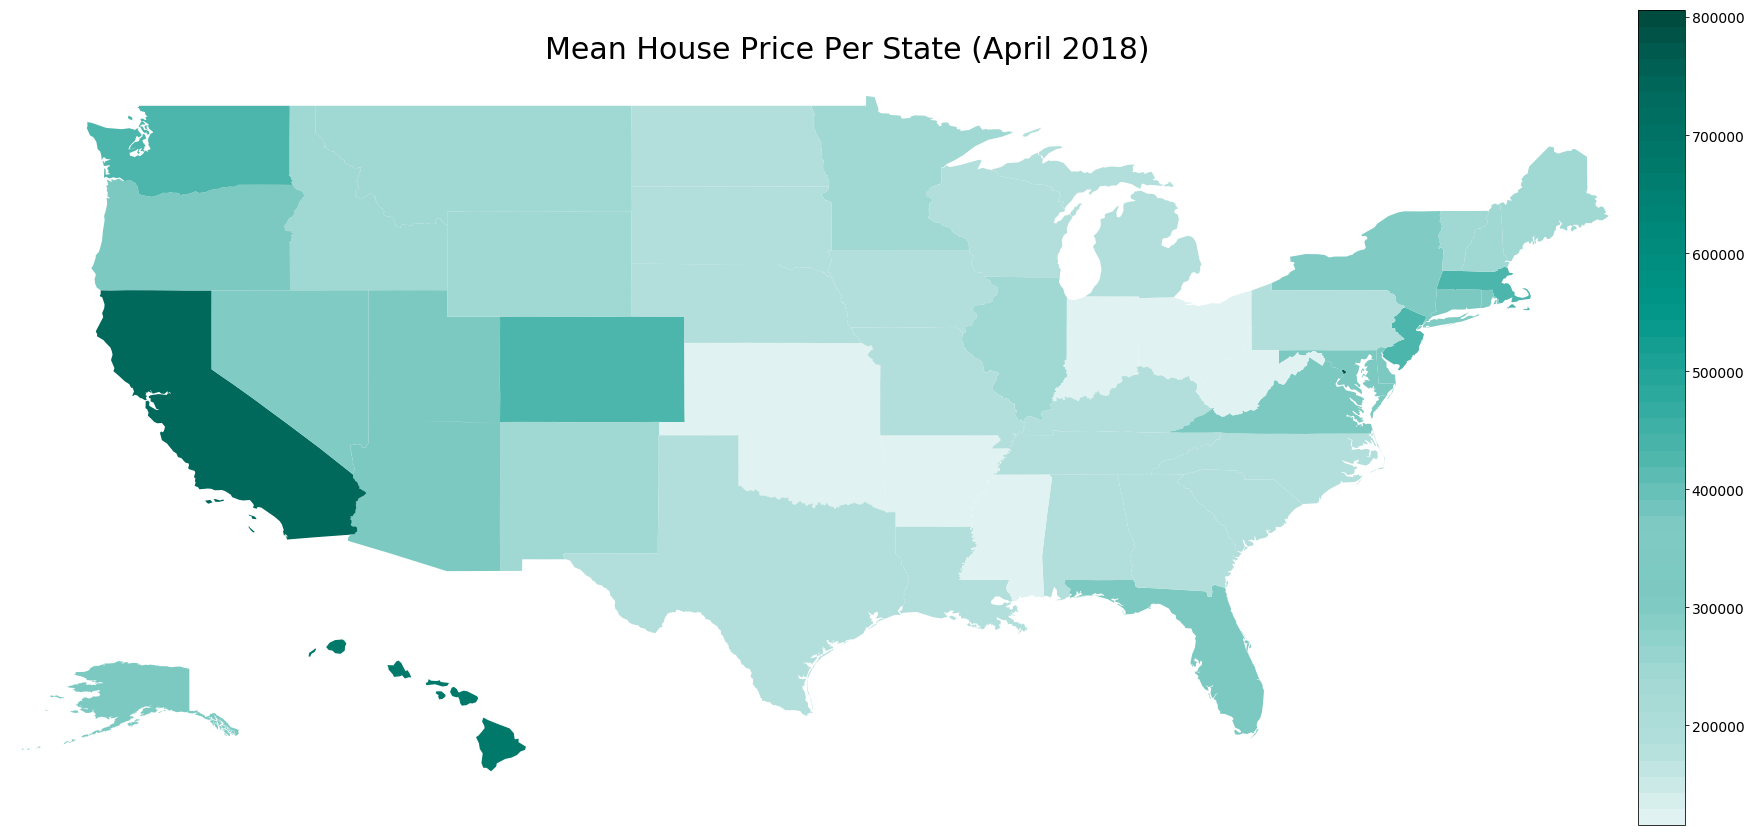

In [15]:
# Look at the mean on a state by state basis
state_map(metric = 'April_2018_mean', title = 'Mean House Price Per State (April 2018)', 
          grad = colorscale2, annot=False, pacific=True)

It looks like California, Hawaii, DC, Colorado, Massachusetts, and New Jersey have the highest medians and means. Also, there appear to be some differences between the mean and median values of some states, which indicates there are most likely some outlier regions. Let's do some digging to see which states have outlier zipcodes that are driving the mean home value for the state up or down.

Maximum median : 785750.0
Maximum mean : 806167.0


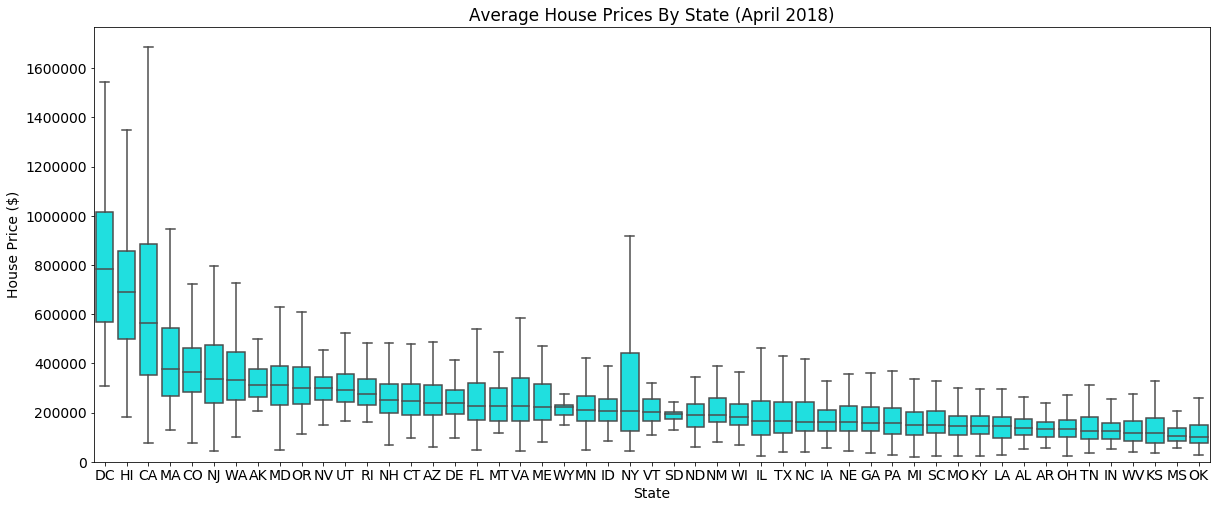

In [16]:
# See if there are any outlier zipcodes that are driving the mean home prices up or down
# Set plot figure:
plt.figure(figsize=(20,8))

# Collect most recent data from April 2018:
y = pd.to_datetime('2018-04', format='%Y-%m')

# Put states in descending order based on their medians:
state_order = states_data['April_2018_median'].sort_values(ascending=False).index

# Create a boxplot for each state:
sns.boxplot(x='State',y=y,
            data=data,order=state_order,
            showfliers=False, color = 'Aqua')

# Set labels and axis limits:
plt.ylim(0,);
plt.xlabel('State')
plt.ylabel('House Price ($)')
plt.title('Average House Prices By State (April 2018)');

# Print maximum mean value
print('Maximum median',':',states_data['April_2018_median'].max().round(0))
print('Maximum mean',':',states_data['April_2018_mean'].max().round(0))

We see further support for outliers being present in some states both when looking at the maximum mean value vs. the maximum median value and when looking at our boxplot chart. It looks like DC on a whole has higher house prices than most other states, followed by Hawaii, California, and Massachusetts, while Oklahoma, Mississippi, Kansas, and West Virgina have the lowest average home prices. Additionally, DC, Hawaii, California, Massachusetts, and New York appear to have some outlier regions that have much higher home prices than most other regions in those states. This indicates that these states are home to some of the most expensive zipcodes to live in.

Another helpful way to look at the data is to see how the spread of home prices has changed over time. This makes it easier to see if there are have been any trends in our data over the years. To do this, I will first create a table including summary data (i.e. mean, min, 50%, max, etc,) and then will plot this data across time. 

In [17]:
# Create an empty dataframe:
sum_stats = pd.DataFrame()

# And summary statistics values we are interested in looking at:
sum_stats['Mean'] = data.mean()
sum_stats['Min'] = data.min()
sum_stats['25%'] = data.quantile(0.25)
sum_stats['50%'] = data.quantile(0.5)
sum_stats['75%'] = data.quantile(0.75)
sum_stats['Max'] = data.max()

# Drop non-date rows that we will not be using and reset the index to be the date:
sum_stats.drop(['RegionID','RegionName','SizeRank'], inplace=True)
sum_stats.reset_index(inplace=True)
sum_stats.tail()

,index,Mean,Min,25%,50%,75%,Max
260,2017-12-01,282527.774329,14300,130600.0,194700.0,315700.0,18307100
261,2018-01-01,284101.379405,14100,131200.0,195300.0,317100.0,18365900
262,2018-02-01,285820.484171,13900,131700.0,196500.0,319050.0,18530400
263,2018-03-01,287967.163253,13800,132500.0,198200.0,321050.0,18337700
264,2018-04-01,289498.834402,13800,133050.0,199600.0,322700.0,17894900


Now that we have the data into a nice dataframe, we can plot it on a graph to visualize the change in house prices over time.

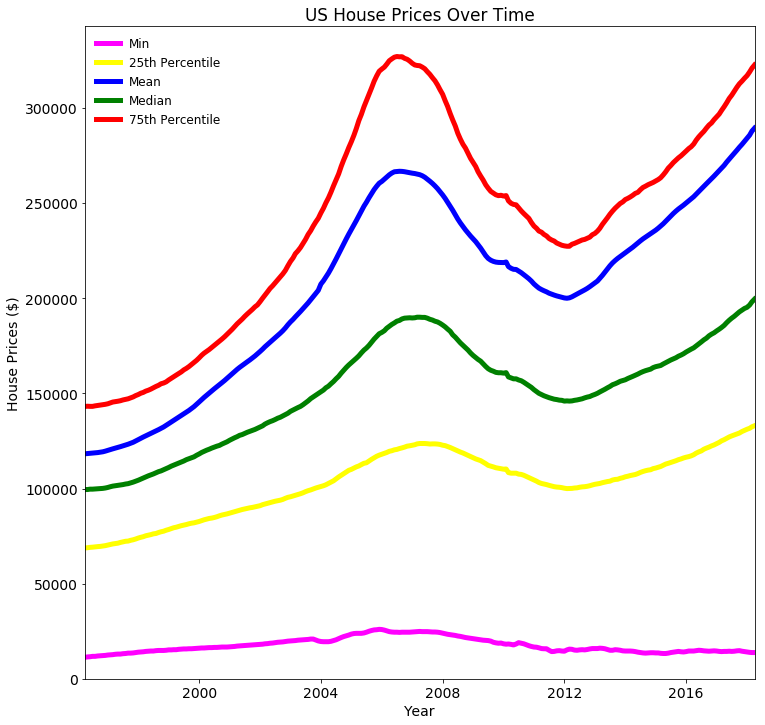

In [18]:
# Initiate figure and select dates for x-axis:
plt.figure(figsize=(12,12))
x = sum_stats['index'].dt.to_pydatetime()

# Plot a different line for each different statistic metric:
plt.plot(x, sum_stats['Min'], lw = 5,
         label = 'Minimum House Price', color=color_list[0])
plt.plot(x, sum_stats['25%'], lw = 5,
         label = '25th Percentile House Price', color=color_list[1])
plt.plot(x, sum_stats['Mean'], lw = 5,
         label = 'Mean House Price', color=color_list[2])
plt.plot(x, sum_stats['50%'], lw = 5,
         label = 'Median House Price', color =color_list[3])
plt.plot(x, sum_stats['75%'], lw = 5,
         label = '75th Percentile House Price', color=color_list[4])

# Add chart labels and limits
plt.xlim(sum_stats['index'][0],sum_stats['index'][len(sum_stats)-1]);
plt.ylim(0,);

plt.title('US House Prices Over Time')
plt.ylabel('House Prices ($)')
plt.xlabel('Year')

# Create a legend:
# Color code the legend to match the plotted lines
custom_lines = [Line2D([0], [0], c=color_list[0], lw=5,
                       markerfacecolor='green', markersize=10),
                Line2D([0], [0], c=color_list[1], lw=5,
                       markerfacecolor='green', markersize=10),
                Line2D([0], [0], c=color_list[2], lw=5,
                       markerfacecolor='green', markersize=10),
                Line2D([0], [0], c=color_list[3], lw=5,
                       markerfacecolor='green', markersize=10),
               Line2D([0], [0], c=color_list[4], lw=5,
                       markerfacecolor='green', markersize=10)]
# Identify labels for legend 
plt.legend(custom_lines,
           ['Min','25th Percentile','Mean','Median',
            '75th Percentile'],
           loc = 2,
           fontsize = 12,
           frameon=False);

We see quite a large gap between the minimum home prices and all other quartiles. The mean values seem to be closer to the 75th percentile rather than to the 50th percentile. We also see that there was a steady increase in house prices from 1996 until 2007, which is when the housing crisis hit. There is then a decline until ~2012 (end of housing recession), where we then start to see house prices grow steadily again. 


The next thing I want to look at is which regions had the best avergae annual growth rate. It is important to look at how much prices have typically grown each year rather than just looking at the final value of a home so that we can incorporate the true potential of the homes based on both their starting value and ending value. I will calculate the growth rate between 1996 and 2007 (when the housing market crashed), 2007 and 2012 (time period when housing market was down), 2012 and 2018 (when housing market recovered to most recent data) and 1996 to 2018 (full range of our data).

In [19]:
# Create a new dataframe to hold our new information:
data_stats = data[list(data.columns[:7])]

# Select the prices from the earliest time:
Apr96 = pd.to_datetime('1996-04', format='%Y-%m')
data_stats['Apr96'] = data[Apr96]

# Select the prices from when the crisis hit (2007):
Apr07 = pd.to_datetime('2007-04', format='%Y-%m')
data_stats['Apr07'] = data[Apr07]

# Select the prices from when the housing market recovered from the crisis (2012):
Apr12 = pd.to_datetime('2012-04', format='%Y-%m')
data_stats['Apr12'] = data[Apr12]

# Select the prices from the most recent time: 
Apr18 = pd.to_datetime('2018-04', format='%Y-%m')
data_stats['Apr18'] = data[Apr18]

# Calculate the average annual growth rate between each desired time frame:
data_stats['\'96-\'07 Growth_Rate %'] = (((data_stats['Apr07'] / data_stats['Apr96'])**(1/11))-1)*100
data_stats['\'07-\'12 Growth_Rate %'] = (((data_stats['Apr12'] / data_stats['Apr07'])**(1/5))-1)*100
data_stats['\'12-\'18 Growth_Rate %'] = (((data_stats['Apr18'] / data_stats['Apr12'])**(1/6))-1)*100
data_stats['\'96-\'18 Growth_Rate %'] = (((data_stats['Apr18'] / data_stats['Apr96'])**(1/22))-1)*100
data_stats.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Apr96,Apr07,Apr12,Apr18,'96-'07 Growth_Rate %,'07-'12 Growth_Rate %,'12-'18 Growth_Rate %,'96-'18 Growth_Rate %
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,912000.0,740300.0,1030600,9.555783,-4.085872,5.668870,5.252174
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,211000.0,201800.0,321800,-1.001332,-0.887657,8.088000,1.425383
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,245100.0,252400.0,329900,1.397454,0.588703,4.563993,2.065492
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,1184800.0,938100.0,1307000,8.196119,-4.562112,5.682824,4.482509
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,126000.0,112800.0,121500,4.541829,-2.188997,1.245997,2.076819


Let's see which 10 regions have the highest average annual growth rate in each of our timeframes to see if there are any regions that have had consistent strong growth.

In [20]:
def growth_rate(column):
    '''
    This function will print the top 10 zip codes with the highest growth rates.
    Parameter:
    column - column within the data_stats dataframe that we want to look at.
    '''

    growth = data_stats.sort_values(by = column,
                                      ascending=False).loc[:,['RegionName','CountyName','State',column]]
    print(column,'\n',growth.head(10),'\n')

# Utilize the growth_rate function for each of our 4 timeframes:   
growth_rate('\'96-\'07 Growth_Rate %')
growth_rate('\'07-\'12 Growth_Rate %')
growth_rate('\'12-\'18 Growth_Rate %')
growth_rate('\'96-\'18 Growth_Rate %')

'96-'07 Growth_Rate % 
        RegionName  CountyName State  '96-'07 Growth_Rate %
13830       19951      Sussex    DE              22.023356
7121        33947   Charlotte    FL              19.682743
11353       86334     Yavapai    AZ              18.632319
1997        19966      Sussex    DE              18.267719
6048        57110   Minnehaha    SD              18.126540
13499       16669  Huntingdon    PA              18.027507
14217       80449        Park    CO              17.600897
10466       31328     Chatham    GA              17.456266
191          7302      Hudson    NJ              17.431526
13690       96703       Kauai    HI              17.378697 

'07-'12 Growth_Rate % 
        RegionName      CountyName State  '07-'12 Growth_Rate %
508         10014        New York    NY              10.009101
20          10011        New York    NY               9.954564
2452        58801        Williams    ND               9.719791
14041       17017  Northumberland    PA          

It looks like we definitely have variation between timeframes, meaning the growth rate for each region has been changing over time.  In recent years, California seems to have a couple of the top growth rate regions.  Since the data seems to change quite a bit over time, I would like to focus on the more recent data for my analysis since I feel that would be most relevant. Therefore, let's take a deeper look at the 2007-2012 and 2012-2018 timeframes to see which states had the most growth rate regions within each timeframe.

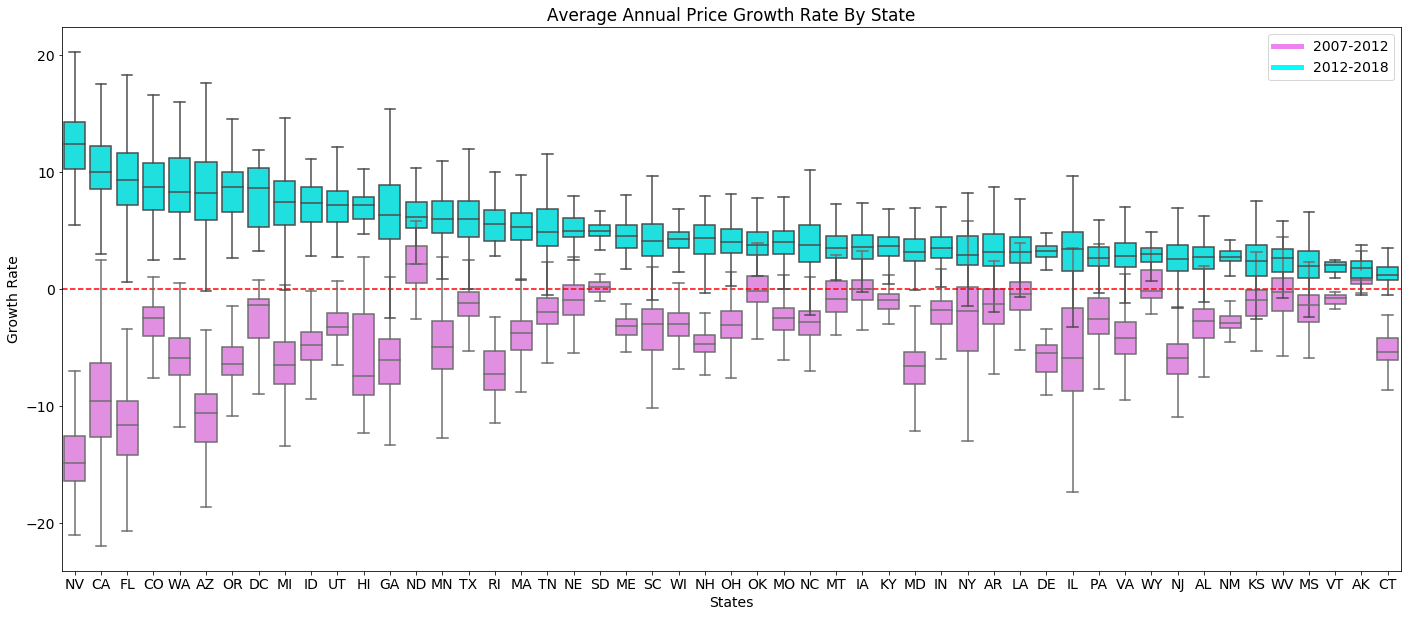

In [21]:
# Plot average annual growth rate for April 2007-April 2012 and April 2012-April 2018 to see
# if the states with the best growth rate in recent years also had the best growth rate during the economic crisis:

# Group the data by state:
group_data_stats = data_stats.groupby('State').mean()

# Setup plot and axes:
fig, ax1 = plt.subplots(figsize=(24, 10))

# Order the data in descending order based on the values from 2012-2018:
state_order = group_data_stats['\'12-\'18 Growth_Rate %'].sort_values(ascending=False).index

# Create plot
plt.axhline(0,color='red',ls="--")

sns.boxplot(x='State',y='\'07-\'12 Growth_Rate %',
            data=data_stats,order=state_order,
            showfliers=False, color = 'violet')

sns.boxplot(x='State',y='\'12-\'18 Growth_Rate %',
            data=data_stats,order=state_order,
            showfliers=False, color = 'aqua')

plt.ylim();
plt.xlabel('States')
plt.ylabel('Growth Rate')
plt.title('Average Annual Price Growth Rate By State');
line_colors = [Line2D([0], [0], c='violet', lw=5,
                       markerfacecolor='green', markersize=10),
                Line2D([0], [0], c='aqua', lw=5,
                       markerfacecolor='green', markersize=10)]

plt.legend(line_colors,('2007-2012','2012-2018'), loc='best');

It looks like many of the states with the highest growth rates in recent years actually had some of the worst growth rates during the housing crisis.  

For my analysis, I want to isolate the regions with the strongest potential so that I have a more reasonably sized dataset to work with. To qualify as a region with strong potential, the region must have above average annual growth rate since the housing market recovered from the crisis (2012), and also have above average annual growth rate during the crisis (2007-2012) to make sure the regions can be strong at the face of adversity. I will isolate these regions band pull them into a new dataframe.

In [22]:
# Calculate the average within each timeframe:
avg_07_12 = data_stats['\'07-\'12 Growth_Rate %'].mean()
avg_12_18 = data_stats['\'12-\'18 Growth_Rate %'].mean()

# Select only the regions with the strongest potential based on having higher than average annual growth rates both 
# in recent years (2012-2018) and during the housing recesion (2007-2012):
data_stats_strong_growth = data_stats.loc[(data_stats['\'07-\'12 Growth_Rate %']>avg_07_12) &
                               (data_stats['\'12-\'18 Growth_Rate %']>avg_12_18)]
strong_growth_regions = list(data_stats_strong_growth['RegionName'])

# Add growth_regions as a column to the original dataframe so that it is easy to determine which regions are and 
# are not growth regions:
data['GrowthRegion'] = data['RegionName'].map(
    lambda x: 1 if x in strong_growth_regions else 0)

# Re-order columns so that GrowthRegion appears before the pricing data:
cols = list(data.columns)
data = data[cols[:7] + [cols[-1]] + cols[7:-1]]

# Create a new dataframe that only includes regions that are considered 'Growth Regions':
data_growth = data.loc[data['GrowthRegion']==1]
data_growth.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,GrowthRegion,1996-04-01 00:00:00,1996-05-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,1,334200.0,335400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1,235700.0,236900.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
3,84616,60614,Chicago,IL,Chicago,Cook,4,1,498100.0,500900.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
5,91733,77084,Houston,TX,Houston,Harris,6,1,95000.0,95200.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,1,95400.0,95600.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


Now that we have selected only data representing regions that have shown strong growth rates, let's see which states have the most growth regions. 

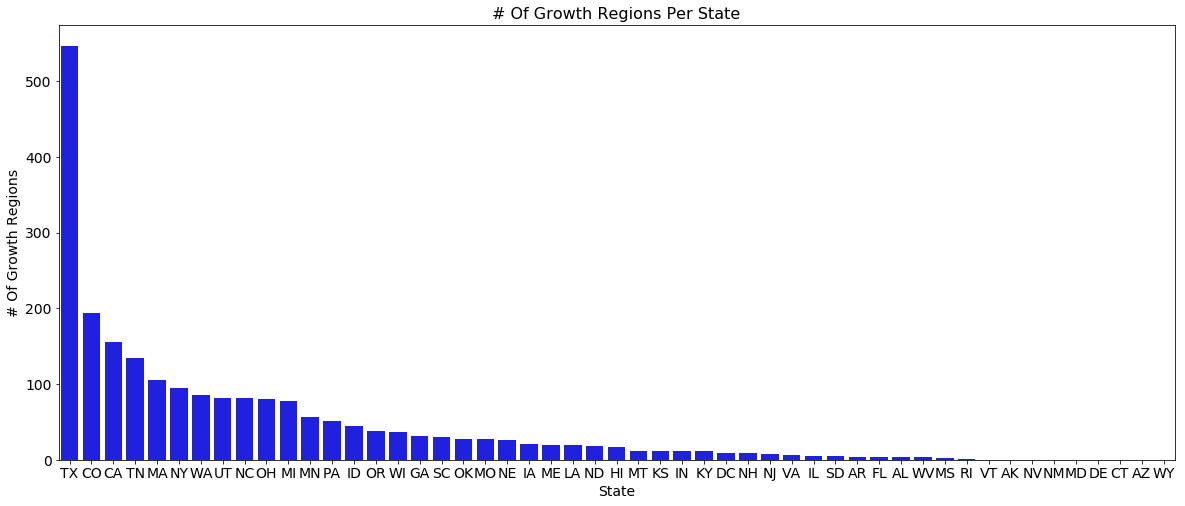

In [23]:
# Create a column with the number of growth regions in each state:
states_data['#GrowthRegions'] = data_growth.groupby('State').sum()['GrowthRegion']

# Fill in states with no growth regions with a zero:
states_data['#GrowthRegions'].fillna(0, inplace=True)

# Order the data in descending order by the # of growth regions per state:
states_ordered = states_data.sort_values('#GrowthRegions', ascending=False)

# Plot what percent of each state's zip codes are growth regions:
y = states_ordered['#GrowthRegions']
x = states_ordered.index
plt.figure(figsize=(20,8))
sns.barplot(x, y, color='b')
plt.xlabel("State")
plt.ylabel("# Of Growth Regions")
plt.title('# Of Growth Regions Per State', fontdict={'fontsize': 16})
plt.show()

On a total level, Texas has the most growth regions, followed by Colorado and California. Let's now see which states have the most growth regions compared to the total number of regions in each state.

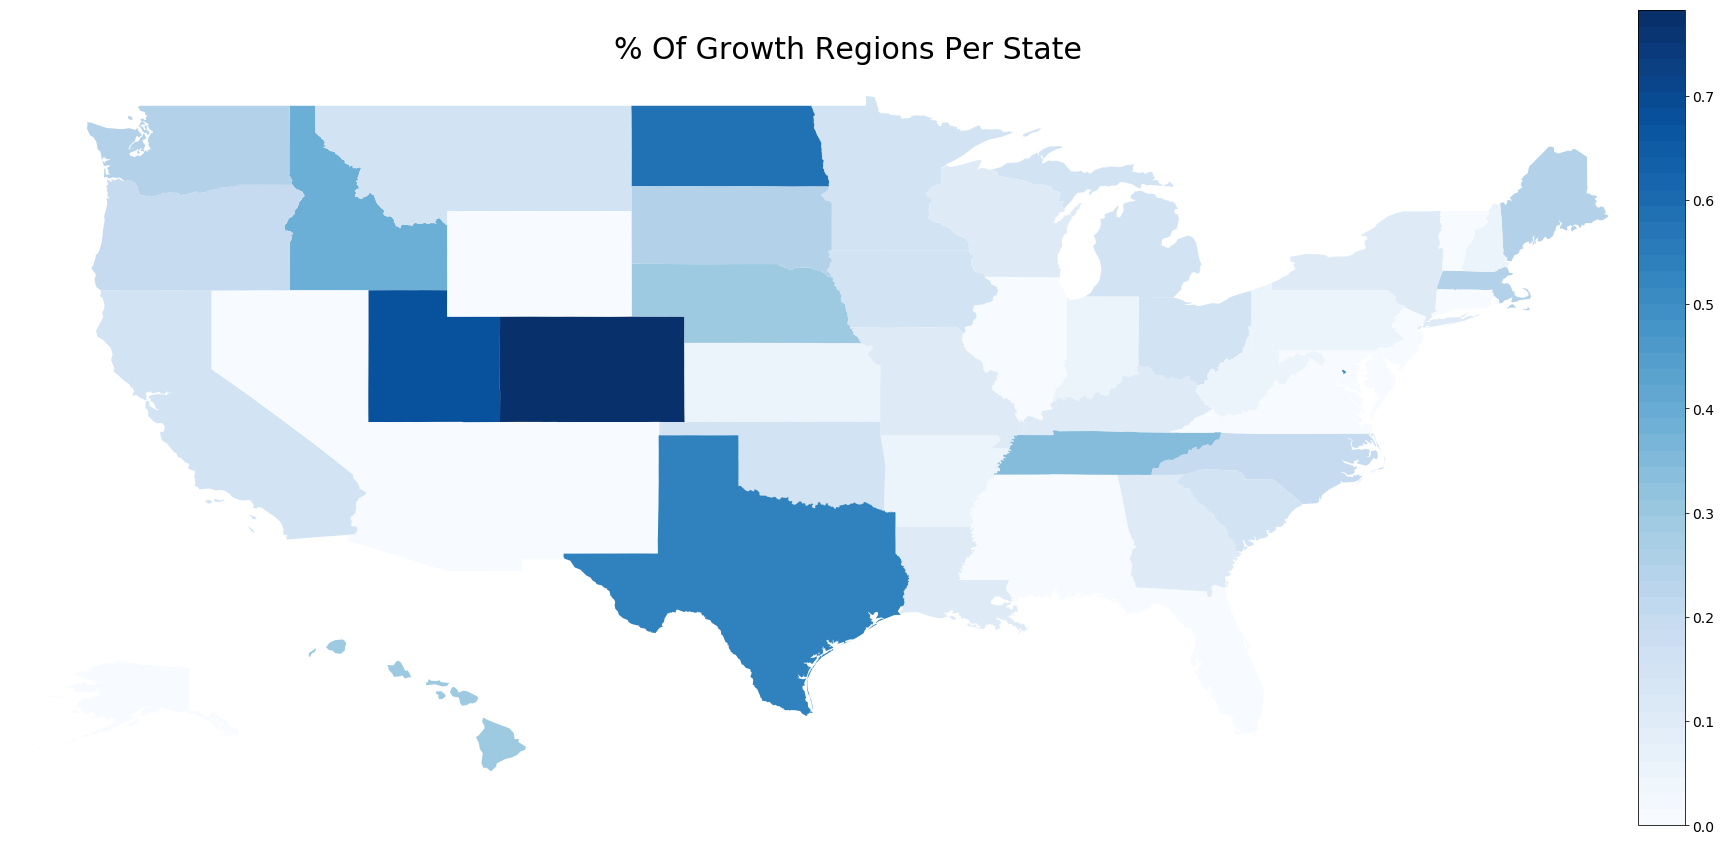

In [24]:
# Create a column that shows share of growth regions in each state:
states_data['%GrowthRegions'] = states_data['#GrowthRegions'] / states_data['RegionCount']

# Plot percentage of growth regiongs on a map:
state_map(metric = '%GrowthRegions', title = '% Of Growth Regions Per State', 
          grad = colorscale, annot=False, pacific=True)

When looking across all states, it looks like Colorado, Utah, Texas, and North Dakota have the highest percentage of growth regions compared to the total number of regions in each state. 

Now that we have explored our data quite a bit, it is time to move into modeling our data so that we can determine which 5 zipcodes are the best to invest in. However, there is one last step we need to take to reformat our data to be usable by the model. Right now, Our data is in Wide format, meaning that each different date is a separate column. Therefore the data only makes sense if you know the name of the column that the data can be found in, which is not helpful when we have metadata like we do here. To fix this problem, I will reformat the data into Long format, which will create one row for each unique time and zipcode combination in the data.

# Step 4: Reshape from Wide to Long Format
I will start by creating a function that will reshape my data from wide to long format, utilizing pandas .melt() function.  I will be using this format to check if there are any trends in our data, and will be using a slightly different format later on for our modeling. Trends can affect the accuracy of our modelling, so we need to know if we have any trends to know whether or not we need to use a model that removes trends. The two things we will look at are if the data has seasonality and if it has stationarity.

First I will reshape the data, then I will remove any unnecessary columns. After that I can check for our trends.

In [25]:
# Create a function to reshape the data from wide to long format:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName','City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

Next I will remove any columns that I no longer need, such as RegionId, SizeRank, GrowthRegion, and any dates prior to April 2012. I will only be focusing on data in recent years since the housing recession was a bit a phenomenon that hopefully will not happen again any time soon. Therefore, I want to focus on performance in recent years when the economy has been regular.

In [26]:
# Select only data from April 2012-April 2018:
data_growth.drop(data_growth.iloc[:,8:200], inplace = True, axis = 1)

# Drop the RegionID, SizeRank, and GrowthRegion columns which do not have relevant information for our analysis"
data_growth = data_growth.drop(columns=['RegionID','SizeRank','GrowthRegion'])

# Check the columns were properly dropped:
data_growth.head()

,RegionName,City,State,Metro,CountyName,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,60657,Chicago,IL,Chicago,Cook,740300.0,744600.0,750500.0,760400.0,771800.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,201800.0,202700.0,203000.0,203000.0,203000.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
3,60614,Chicago,IL,Chicago,Cook,938100.0,951900.0,965400.0,975900.0,984500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
5,77084,Houston,TX,Houston,Harris,112000.0,111800.0,111700.0,111700.0,111800.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,77449,Katy,TX,Houston,Harris,115200.0,114700.0,114700.0,115100.0,115500.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


With our dataframe ready, we can now utilize the melt_data function to transform our data into the desired long format. Once transformed, I will then graph the data to see what it looks like.

In [27]:
# Apply the melt_data function:
model_data = melt_data(data_growth)
model_data.head()

,value
time,
2012-04-01,275469.990934
2012-05-01,277096.010879
2012-06-01,278736.582049
2012-07-01,280359.474161
2012-08-01,281999.728015


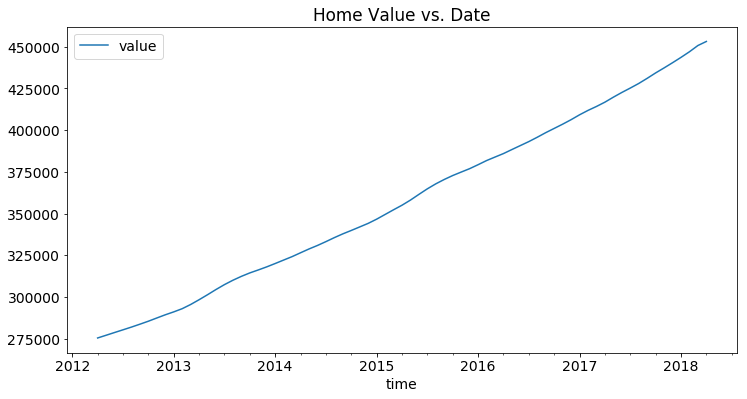

In [28]:
# Plot our time series:
model_data.plot(figsize=(12,6))
plt.title('Home Value vs. Date');

Great, now we have our data in the desired long format. It looks like we have a steady upward trend in home prices since 2012. Before we are able to model, we first need to check if our time series has any trends. Trends can affect the accuracy of our modelling, and will need to be removed if present. The two things we will look at are if the data has seasonality and if it has stationarity.

#### Seasonality
If our data has a seasonality trend (i.e. pumpkin spice cookies which peak every fall and are not purchased often the rest of the year), then we would need to remove this trend prior to modelling. We can see from the plot above that there are no recurring spikes in our graph, indicating that we do not have any seasonality here.

#### Stationarity
A time series has stationarity if its statistical properties (i.e. mean variance, etc.) remain constant over time. Most models need stationarity to run properly. To see if our data has stationarity, I will use the rolling statistics method, which will plot the moving average and variance to see if it varies over time. If we see variation, then our data does not have stationarity which will need to be dealt with prior to modeling. I will also use the Dickey-Fuller test to check statistically if we have stationarity. I will build a function that runs both of these methods so that it is easy to re-use in the future.

In [29]:
def stationarity_check(df):
    '''
    This function will chart the results from the rolling statistics method to visualize if we have stationarity.
    It will then run a Dickey_fuller test to see if stationarity exists from a statistical standpoint.
    Parameters:
    df - data we want to test
    '''
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = df.rolling(window=8, center=False).mean()
    roll_std = df.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(df['value'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

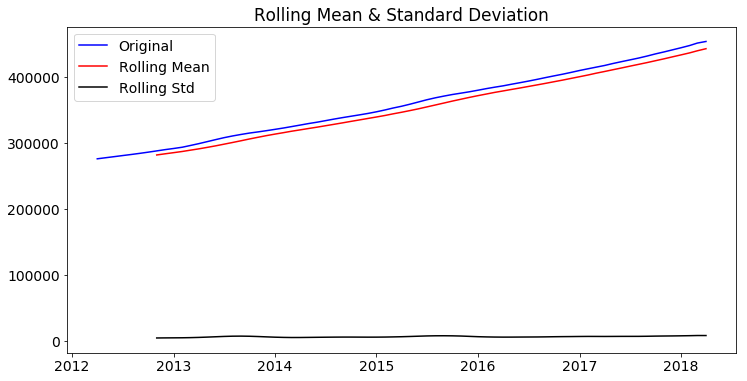

Results of Dickey-Fuller Test: 

Test Statistic                  1.661743
p-value                         0.998031
#Lags Used                      4.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [30]:
# Run stationarity_check function:
stationarity_check(model_data)

We can see here that the rolling mean is not constant over time and we have a high p-value that is greater than our desired 5% critical value, implying that our data does not have stationarity. This means our data has a trend that will need to be removed. Luckily, the ARIMA model is a model version that can remove trends for us so that we do not have to do so separately. The ARIMA model will use differencing to remove the trends in our data prior to modeling.

# Step 5: ARIMA Modeling

We will be using ARIMA, which is an integrated ARMA model. This model is typically used when we have a non-stationary series with a trend, but no seasonality. The integrated aspect will remove the trends that we have and then proceed with modeling. There are 3 parameters that this model depends on:
1. Number of AR (Auto-Regressive) terms (p) - incorporates the effect of past values into our model.
2. Number of Differences (d) - integrated component that deals with trends.This identifies the amount of differencing needed based on the number of lag values to subtract from the current observation.
3. Number of MA (Moving Average) terms (q) - moving average used to set the error of the model as a linear combination of the error values observed at previous time points.

These parameters help identify the order that will give the best possible ARIMA model. We will first need to identify these parameters, and then can use them in the modeling process. To make things easier, we will define a couple of functions that will allow us to iterate through a given list of regions, fit the best ARIMA model to the dataset, and return some summary statistics about each model.  When running our models, we will make sure to first split our data into train and test sets (using standard 70/30 split) so that we can easily validate our model.

As I had mentioned earlier, I am going to slightly change the format of my dataframe when modeling. We still need the data to be in the long format, but for the technique I am using it will be most helpful to have each region in its own column of the dataframe. The below function will allow me to create the dataframe format I need when given a list of regions.

In [31]:
def regions_dataframe(regions, start = '2012-04-01', end = '2018-04-01', data = data):
    
    '''
    Given a list of regions along with a start and end date, this returns a long format time series dataframe 
    with each region having its own column
    
    Parameters:
    - regions (list) - The regions we want to keep
    - start (str) - The date we want to start with in our dataframe ('YYYY-MM-DD')
    - end (str): The date to we want to end with in our dataframe ('YYYY-MM-DD')
    - data (dataframe): The dataframe we will use
    '''
    
    # If a single region is entered, turn this entry into a list:
    if type(regions) != list:
        regions = [regions]
    
    # Update the start and end date to be in datetime format:
    start = pd.to_datetime(start, format='%Y-%m')
    end = pd.to_datetime(end, format='%Y-%m')
    
    # Create a new dataframe that only includes the regions we want to look at:
    data_temp = data.loc[data['RegionName'].isin(regions)]
    
    # Set the RegionName column to be in string format (needed for ARIMA model) and reset this column to be the index:
    data_temp['RegionName'] = data_temp['RegionName'].astype(str)
    data_temp.set_index(['RegionName'],inplace=True)

    # Identify the columns representing our start date and our end date:
    columns = list(data_temp.columns)
    start_index = columns.index(start)
    end_index = columns.index(end)
    
    # Isolate the columns within our start and end dates. Then transpose the dataframe so the dates are in the index:
    data_temp = data_temp.iloc[:,start_index:end_index+1].T
    
    # Reset the index back to the date:
    data_temp.reset_index(inplace=True)
    data_temp.set_index('index',inplace=True)
    
    return data_temp

To determine what ranges to look at for our ARIMA model parameters, let's plot the autocorrelation and partial autocorrelation. These charts will help us understand the correlation between the time series and its lag.

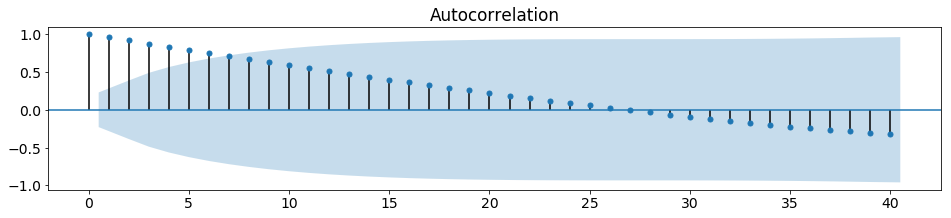

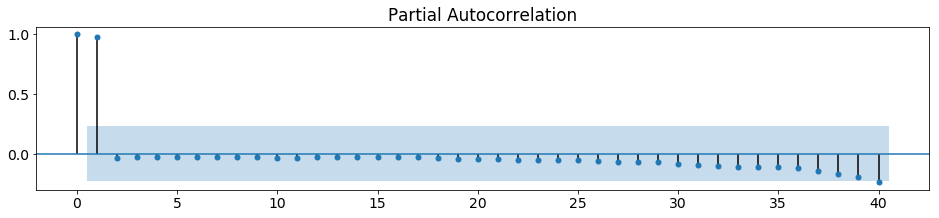

In [32]:
# Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(model_data,ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(model_data,ax=ax, lags=40);

From this, we can determine that a range between 0 and 2 should be used for our parameters.
Now lets create the additional functions needed to model our data and produce an easy to use dataframe with the output. 

In [33]:
# Define the 3 parameters used in an ARIMA model:
p = q = d = [0,1,2]
d = [0,1]

# Create a list with all possible compinations of these 3 parameters:
combs = list(itertools.product(p,d,q))


def arima_selection(dataset, combs=combs, split=0.7):
    
    '''
    Given a dataset, this function will provide us with the best (p,d,q) order that minimizes the root mean squared
    error on the test set and the best fitted ARIMA model
    
    Parameters:
    - dataset -  The dataset we will be fitting to the model
    - combs - List of the possible combinations of (p,d,q)
    - split - What percent of the data we want in our training set
    '''
    
    # Calculate the index to be used to define the train test split:
    limit = int(len(dataset) * split)
    
    # Create the train and test sets:
    train = dataset[:limit]
    test = dataset[limit:]
    
    # Declare each variable that we will work with (to be updated later):
    rmse = None
    best_model = None
    best_order = None
    best_rmse = 10000000
    
    # Loop through all (p,d,q) combinations:
    for i in combs:
        try:
            # Run ARIMA model and fit it to the training set:
            model = ARIMA(train,order=i)
            output = model.fit()
            # Forecast the same length as the length of the testing set:
            pred = output.forecast(len(test))[0]
            # Calculate the root mean square error:
            rmse = mean_squared_error(test, pred)**0.5
            
            # If there is a new best RMSE, update the RMSE and model parameter variables:
            if rmse < best_rmse:
                best_order = i
                best_rmse = rmse
                best_model = output

        except:
            continue
            
    if rmse == None:
        return None
    else:
        return best_order, best_model



def arima_forecast(output, periods):
    
    '''
    Given output from a fitted ARIMA model and a designated number of periods, provides a series of forecasts, 
    lower bounds, and upper bounds.
    
    Parameters:
    - output - A fitted ARIMA model (in object format)
    - periods - # of periods into the future we want to forecast
    '''

    # Calculate the forecast, lower bounds, and upper bounds:
    forecast = output.forecast(periods)
    lower = [i[0] for i in forecast[2]]
    upper = [i[1] for i in forecast[2]]

    return forecast[0], lower, upper



def arima_output(region, start='2012-04-01', periods = 120,
                 split = 0.7, combs = combs):
    
    '''
    Given an individual region, produces a row in the dataframe that includes general 
    information along with modelled ARIMA related data for the given region
    
    Parameters:
    - region - the region to evaluate
    - start - the first date to include from the dataframe
    - periods - the number of periods (months) to forecast
    - split - what percent of the data we want in our training set
    - combs -  list of the possible combinations of (p,d,q)
    '''    
    
    # Format region data into correct dataframe format:
    df = regions_dataframe(region,start=start)

    # Run and choose best ARIMA model:
    order, output = arima_selection(dataset=df, combs=combs, split=split)
    
    # If no model can be fit to the region's data, return None to avoid having N/As that our model cannot read:
    if order == None:
        return None

    # If model can be fit, run forecast and pull necessary data into a dataframe for easy use access:
    else:
        forecast, lower, upper = arima_forecast(output=output, periods=periods)

        state = data.loc[data['RegionName']==region]['State'].item()
        county = data.loc[data['RegionName']==region]['CountyName'].item()

        df_temp = pd.DataFrame({'RegionName':[region],
                                'County':[county],
                                'State':[state],
                                'Order':[order],
                                'FittedModel':[output],
                                'Forecast':[forecast],
                                'Lower':[lower],
                                'Upper':[upper]})

        return df_temp



def arima_dataframe(regions, start='2012-04',
                    periods = 120, split = 0.7, combs = combs):
    
    '''
    Given a list of regions, produces a dataframe which includes all necessary information about the region 
    and the forecasted data from the ARIMA model
    
    Parameters:
    - regions - list of regions (based on zip codes) that we want to evaluate
    - start -  the first date to include from the dataframe
    - periods: the number of periods (months) to forecast
    - split - what percent of the data we want in our training set
    - combs -  list of the possible combinations of (p,d,q)
    '''
    
    # Create an empty dataframe:
    df_temp = pd.DataFrame()
    
    # Iterate through each region in the given list and isolate the statistics we want from the arima_output
    # function, then adding the information for each reach to the dataframe just created:
    for i in regions:
        region_df = arima_output(i, start=start,
                                 periods=120, split=.9)
        df_temp = pd.concat([df_temp,region_df])
    
    return df_temp

Now that we have all our functions defined, we can run our data through the functions (which includes our modelling) and see what output we are getting. I am only going to look at the regions we previously identified as strong growth regions in order to focus on the regions with the greatest potential. 

It can take a while to run all of these functions for the large dataset we have, so I have used pickle to ensure we don't have to re-run this function each time we open this notebook.

In [36]:
# Create Dataframe with data from the above modelling functions
# arima_data = arima_dataframe(strong_growth_regions)

# Pickle out the data
#with open('arima_data.pickle', 'wb') as f:
#    pickle.dump(arima_data, f, pickle.HIGHEST_PROTOCOL)

In [34]:
# Use pickle to collect the previously run data:
with open('arima_data.pickle', 'rb') as file:
    arima_data = pickle.load(file)

# Reset the index and take a look at our dataframe:
arima_data.reset_index(inplace=True, drop=True)
arima_data.head()

,RegionName,County,State,Order,FittedModel,Forecast,Lower,Upper
0,60657,Cook,IL,"(2, 1, 1)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[1008400.5343120397, 1010670.1996364215, 10145...","[1004681.0177518534, 1000650.3124298838, 99852...","[1012120.050872226, 1020690.0868429593, 103053..."
1,75070,Collin,TX,"(2, 0, 2)",<statsmodels.tsa.arima_model.ARMAResultsWrappe...,"[312142.52864253905, 314062.361511311, 315780....","[311294.7259809129, 311720.7150464696, 311645....","[312990.3313041652, 316404.00797615247, 319916..."
2,60614,Cook,IL,"(1, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[1285939.7733391253, 1286058.8039017846, 12888...","[1282480.8049918492, 1275404.246762409, 126950...","[1289398.7416864014, 1296713.36104116, 1308143..."
3,77084,Harris,TX,"(2, 0, 2)",<statsmodels.tsa.arima_model.ARMAResultsWrappe...,"[159748.65322587258, 160656.73221875186, 16143...","[159292.74282737751, 159377.6667162249, 159171...","[160204.56362436764, 161935.79772127882, 16368..."
4,77449,Harris,TX,"(1, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[168312.64732798171, 169293.87441570518, 17021...","[167829.80409918047, 168010.76537666042, 16795...","[168795.49055678296, 170576.98345474995, 17248..."


Great! Now we have our fitted model, forecasted values, and lower and upper bounds for each region. Within the FittedModel column, we are able to extract some additional information (i.e. parameters, AIC, BIC, P-values). We will be using the p-values later on, so I am going to extract those p-values and add them in as a new column.

Additionally, in some cases, we are unable to fit a model, so we will want to remove those regions since we don't have a proper analysis for them.

In [35]:
# Extract p-values from FittedModel column and add them to a new column:
arima_data['P-Values'] = arima_data['FittedModel'].map(lambda x: x.pvalues)

# Remove regions where a model was unable to be fit:
arima_data.dropna(inplace=True)

# Step 6: Interpreting Results

Now that we have all of our modelled data ready to go, it's time to interpret our results!

To start, I will be looking at the average annual growth rate over a 5 and 10 year period. This will give us a better understanding of how each region looks year over year rather than just looking at an arbitrary time period length. Having a higher average growth rate year after year indicates greater potential from an investment stand point.

In [36]:
# Add in columns for average annual growth rate of 5 years and 10 years:
arima_data['Annual_5y_GrowthRate'] = arima_data['Forecast'].map(lambda x: (((x[59]/x[0])**(1/5))-1)*100)
arima_data['Annual_10y_GrowthRate'] = arima_data['Forecast'].map(lambda x: (((x[-1]/x[0])**(1/10))-1)*100)

# Add in column to evaluate the difference in home values forecasted in 10 years compared to now:
arima_data['Growth_Over_10yrs'] = arima_data['Forecast'].map(lambda x: x[-1] - x[0])

# Sort data in descending order based on the average annual growth rate over 10 years:
arima_data.sort_values('Annual_10y_GrowthRate', ascending=False).head()

,RegionName,County,State,Order,FittedModel,Forecast,Lower,Upper,P-Values,Annual_5y_GrowthRate,Annual_10y_GrowthRate,Growth_Over_10yrs
1515,37190,Cannon,TN,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[127373.91637115147, 128189.09746547627, 12904...","[126737.59453666929, 126447.52400848595, 12591...","[128010.23820563365, 129930.67092246658, 13217...",const 2.719797e-12 ar.L1.D.37190 ...,15.805994,17.694515,522221.203113
1523,23230,Henrico,VA,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[207696.17537108052, 210456.40947133262, 21328...","[206557.1020514213, 207371.95359211587, 207755...","[208835.24869073974, 213540.86535054937, 21880...",const NaN ar.L1.D.23230 ...,18.383052,16.905738,782649.425931
1344,81008,Pueblo,CO,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[175087.8749338357, 176030.12308280473, 177027...","[174312.4483168684, 174066.22336590974, 173581...","[175863.301550803, 177994.0227996997, 180473.1...",const NaN ar.L1.D.81008 ...,14.217953,16.113714,604906.114025
643,79605,Taylor,TX,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[103667.40259053996, 104666.98125075005, 10569...","[102985.47537071949, 102722.26340576234, 10216...","[104349.32981036043, 106611.69909573776, 10923...",const 1.191808e-01 ar.L1.D.79605 ...,15.936598,15.593791,337890.126460
1168,76015,Tarrant,TX,"(2, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[166371.6724471999, 168679.1149821141, 171022....","[165511.4486577587, 166283.62759351503, 166692...","[167231.8962366411, 171074.60237071314, 175352...",const NaN ar.L1.D.76015 ...,17.081774,15.565314,540522.544994


One of the qualifications we will use (more detail to come soon) to define our best regions is that the p-values must be less than alpha=.05 to ensure they are statistically significant (meaning we don't have any trends). Therefore, let's filter out any regions where the p-value is not statistically significant as these regions are not good options for us to consider. We will put the max p-value in a new column so that we can use it later on for our qualification.

In [37]:
# Create function to filter out regions with non-statistically-significant p-values:
def max_no_na(x):
    if len(list(x.dropna())) == 0:
        return None
    else:
        return max(list(x.dropna()))

# Add maximum p-value as it's own column to the dataframe:
arima_data['Max_P-Value'] = arima_data['P-Values'].map(lambda x: max_no_na(x))
arima_data.head()

,RegionName,County,State,Order,FittedModel,Forecast,Lower,Upper,P-Values,Annual_5y_GrowthRate,Annual_10y_GrowthRate,Growth_Over_10yrs,Max_P-Value
0,60657,Cook,IL,"(2, 1, 1)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[1008400.5343120397, 1010670.1996364215, 10145...","[1004681.0177518534, 1000650.3124298838, 99852...","[1012120.050872226, 1020690.0868429593, 103053...",const 3.266306e-09 ar.L1.D.60657 ...,4.385098,4.024437,487789.627927,0.001261
1,75070,Collin,TX,"(2, 0, 2)",<statsmodels.tsa.arima_model.ARMAResultsWrappe...,"[312142.52864253905, 314062.361511311, 315780....","[311294.7259809129, 311720.7150464696, 311645....","[312990.3313041652, 316404.00797615247, 319916...",const 1.897023e-07 ar.L1.75070 0...,-1.082745,-1.579186,-45933.701148,0.933850
2,60614,Cook,IL,"(1, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[1285939.7733391253, 1286058.8039017846, 12888...","[1282480.8049918492, 1275404.246762409, 126950...","[1289398.7416864014, 1296713.36104116, 1308143...",const 8.410491e-05 ar.L1.D.60614 ...,4.378911,4.070478,630504.095792,0.000084
3,77084,Harris,TX,"(2, 0, 2)",<statsmodels.tsa.arima_model.ARMAResultsWrappe...,"[159748.65322587258, 160656.73221875186, 16143...","[159292.74282737751, 159377.6667162249, 159171...","[160204.56362436764, 161935.79772127882, 16368...",const 1.640015e-12 ar.L1.77084 1....,-1.201460,-1.273600,-19218.271009,0.952955
4,77449,Harris,TX,"(1, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[168312.64732798171, 169293.87441570518, 17021...","[167829.80409918047, 168010.76537666042, 16795...","[168795.49055678296, 170576.98345474995, 17248...",const 2.714557e-03 ar.L1.D.77449 ...,4.821198,4.339263,89078.968129,0.158462


When forecasting future values, having a smaller predicition interval range leads to a more accurate predicted value. Therefore, it will be helpful to calculate how wide the prediction interval is for each region in the last predicted time period.

In [38]:
def predicted_interval_width(region):
    
    '''
    Given a region, calculates the difference between the upper and lower bounds (at a 95% confidence interval)
    in the last forecasted time period.
    '''
    
    # Select data corresponding to the desired region:
    desired_region = arima_data.loc[arima_data['RegionName']==region]

    # Select the lower and upper bounds for the last forecasted period:
    lower_bound = desired_region['Lower'].item()[-1]
    upper_bound = desired_region['Upper'].item()[-1]
    
    # Return the difference between upper and lower bounds:
    return (upper_bound - lower_bound)

# Add column to dataframe with the width of the predicted bounds:
arima_data['PredictedWidth'] = arima_data['RegionName'].map(
    lambda x: predicted_interval_width(x))
arima_data.head()

,RegionName,County,State,Order,FittedModel,Forecast,Lower,Upper,P-Values,Annual_5y_GrowthRate,Annual_10y_GrowthRate,Growth_Over_10yrs,Max_P-Value,PredictedWidth
0,60657,Cook,IL,"(2, 1, 1)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[1008400.5343120397, 1010670.1996364215, 10145...","[1004681.0177518534, 1000650.3124298838, 99852...","[1012120.050872226, 1020690.0868429593, 103053...",const 3.266306e-09 ar.L1.D.60657 ...,4.385098,4.024437,487789.627927,0.001261,239655.795158
1,75070,Collin,TX,"(2, 0, 2)",<statsmodels.tsa.arima_model.ARMAResultsWrappe...,"[312142.52864253905, 314062.361511311, 315780....","[311294.7259809129, 311720.7150464696, 311645....","[312990.3313041652, 316404.00797615247, 319916...",const 1.897023e-07 ar.L1.75070 0...,-1.082745,-1.579186,-45933.701148,0.933850,223321.791052
2,60614,Cook,IL,"(1, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[1285939.7733391253, 1286058.8039017846, 12888...","[1282480.8049918492, 1275404.246762409, 126950...","[1289398.7416864014, 1296713.36104116, 1308143...",const 8.410491e-05 ar.L1.D.60614 ...,4.378911,4.070478,630504.095792,0.000084,478870.813947
3,77084,Harris,TX,"(2, 0, 2)",<statsmodels.tsa.arima_model.ARMAResultsWrappe...,"[159748.65322587258, 160656.73221875186, 16143...","[159292.74282737751, 159377.6667162249, 159171...","[160204.56362436764, 161935.79772127882, 16368...",const 1.640015e-12 ar.L1.77084 1....,-1.201460,-1.273600,-19218.271009,0.952955,86652.768991
4,77449,Harris,TX,"(1, 1, 2)",<statsmodels.tsa.arima_model.ARIMAResultsWrapp...,"[168312.64732798171, 169293.87441570518, 17021...","[167829.80409918047, 168010.76537666042, 16795...","[168795.49055678296, 170576.98345474995, 17248...",const 2.714557e-03 ar.L1.D.77449 ...,4.821198,4.339263,89078.968129,0.158462,86407.113950


We now have everything that we need to determine what the best 5 regions are! There are 4 qualifications that I am looking at to decide if a region can qualify as being one of 'the best' regions. Those qualifications are:
1. Needs to have a 5yr average annual growth rate in the top 25% of the dataset
2. Needs to also have a 10 yr average annual growth rate in the top 25% of the dataset
3. Needs a narrow predicted interval width to ensure a more accurate forecasted value (interval width must be within 50% of the smallest interval widths)
4. The maximum p-value must be less than alpha=.05 to ensure we are statistically significant and no longer have trends present.

I am using these qualifications because I want regions that consistently have strong annual growth rates and I want my predictions to be as accurate as possible.

Let's see which 5 regions meet all of these qualifications and have the highest predicted overall return after 10 years, meaning they are our best 5 regions.

In [39]:
# Identify the regions that fall into each of the different parameters:
top25_5yr = arima_data['Annual_5y_GrowthRate'].quantile(.75)
top25_10yr = arima_data['Annual_10y_GrowthRate'].quantile(.75)
top50_width = arima_data['PredictedWidth'].quantile(.5)

# Identify which 5 regions are our 'best regions':
best_regions = list(arima_data.loc[(arima_data['Annual_5y_GrowthRate'] > top25_5yr) &
                                 (arima_data['Annual_10y_GrowthRate'] > top25_10yr) &
                                 (arima_data['PredictedWidth'] < top50_width) &
                                 (arima_data['Max_P-Value'] < 0.05)].sort_values(
    'Growth_Over_10yrs', ascending=False)['RegionName'][:5])

# Print a list of the best 5 regions along with their zip codes.
for i in best_regions:
    print(list(arima_data.loc[arima_data['RegionName'] == i, 'County']),i)

['Los Angeles'] 91011
['Middlesex'] 2143
['Middlesex'] 2460
['Denver'] 80209
['Denver'] 80220


We have successfully identified our 5 best regions, which are Los Angeles (91011), Middlesex (02143), Middlesex (02460), Denver (80209), and Denver (80220). Let's take a look at what the projected forecasted values of these regions looks like visually.

In [40]:
def plot_forecasts(regions, labels=None, plot_width=True,
                   start='2012-04', months=120, size=(16,10)):    
    '''
    Given a list of regions, plot their actual values for a desired number of periods along with their 
    future predicted values for a desired number of periods
    
    Parameters:
    - regions - list of region(s) to plot 
    - labels - region names for the legend
    - plot_width - if True plots the width of the forecast
    - start - first date we want to include
    - months - # of forecasted months to include
    - size - size of the plot
    '''
    
    # If single region provided, convert it to a list:
    if type(regions) != list:
        regions = [regions]
    
    # Create a plot figure:
    plt.figure(figsize=size)
    
    # Create a color counter:
    counter=0
    
    # Iterate through each region and plot the desired values:
    for i in regions:
        # Select the real values from past years:
        data_real = regions_dataframe(i).iloc[:-7,:]
        x_real = list(data_real.index)
        y_real = data_real

        # Indicate how long the x axis needs to be for the forecasts:
        x_length = pd.date_range('2017-10-01', periods=months, freq='MS')
        
        # Identify the desired region:
        region_i = arima_data.loc[arima_data['RegionName']==i]
        
        # Specify the label to be associated with that region:
        if labels == None:
            label = f"{region_i['County'].item()} County, {region_i['State'].item()} ({region_i['RegionName'].item()})"
        else:
            label = f"{labels[counter]}, {region_i['State'].item()}"
        
        # Select the region's forecasted values:
        y_forecast = region_i['Forecast'].item()[:months]

        # Identify the color to be used for each region:
        color = color_list[counter]
        
        # Plot the real and forecasted values:
        plt.plot(x_real, y_real, color=color, label = label, lw = 4)
        plt.plot(x_length,y_forecast, color=color, ls='--', label = '', lw = 4)
        
        # If showing the interval widths, plot the bounds and shade between them:
        if plot_width==True:
            lower = region_i['Lower'].item()[:months]
            upper = region_i['Upper'].item()[:months]
            plt.fill_between(x_length, lower, upper,
                 facecolor=color, alpha = 0.15, interpolate=True)
        
        # Add 1 to the counter so a new color is chosen for the next region:
        counter += 1

    # Plot labels and axis limits:
    plt.title('Housing Price Forecasts and Bounds')
    plt.xlabel('Year')
    plt.ylabel('Avearge House Prices in Region ($)');
    
    plt.xlim(pd.to_datetime('2012-04', format='%Y-%m'),x_length[-1])
    plt.ylim(0,)

    plt.legend(loc=2, fontsize=14, frameon=True);

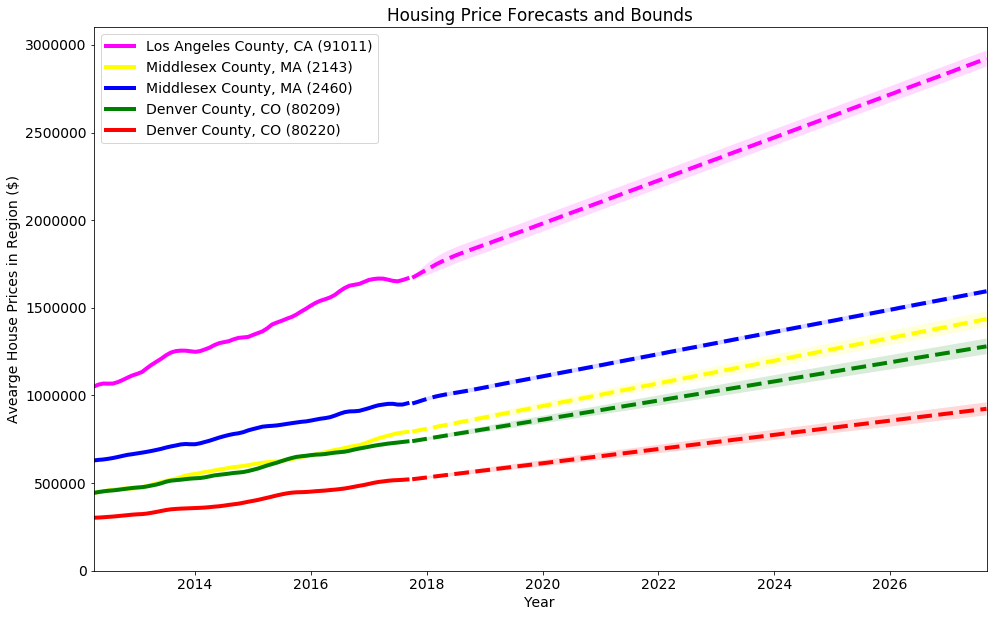

In [41]:
# Plot our 5 best regions:
plot_forecasts(best_regions)

We can see that Los Angeles specifically seems to have quite a lot of forecasted growth over the 10 year period. Let's print out what this absolute growth is along with the growth rates for each of our 5 regions.

In [42]:
# Calculate 10 year absolute growth and percentage growth for these 5 regions:
for i in best_regions:
        print('Region:',i,'-->', '10 Year Absolute Growth:','$',
              arima_data.loc[arima_data['RegionName'] == i]['Growth_Over_10yrs'].values,
             '-->', '10 Year Annual Growth Rate:',
              arima_data.loc[arima_data['RegionName'] == i]['Annual_10y_GrowthRate'].values, '%')

Region: 91011 --> 10 Year Absolute Growth: $ [1249665.27735994] --> 10 Year Annual Growth Rate: [5.74043227] %
Region: 2143 --> 10 Year Absolute Growth: $ [641670.3125] --> 10 Year Annual Growth Rate: [6.10081607] %
Region: 2460 --> 10 Year Absolute Growth: $ [640155.5443805] --> 10 Year Annual Growth Rate: [5.26675332] %
Region: 80209 --> 10 Year Absolute Growth: $ [540706.25] --> 10 Year Annual Growth Rate: [5.64114297] %
Region: 80220 --> 10 Year Absolute Growth: $ [401810.9375] --> 10 Year Annual Growth Rate: [5.87203378] %


Let's now chart this absolute growth along with the growth rate for each region to get a better visual understanding of the potential of each region.

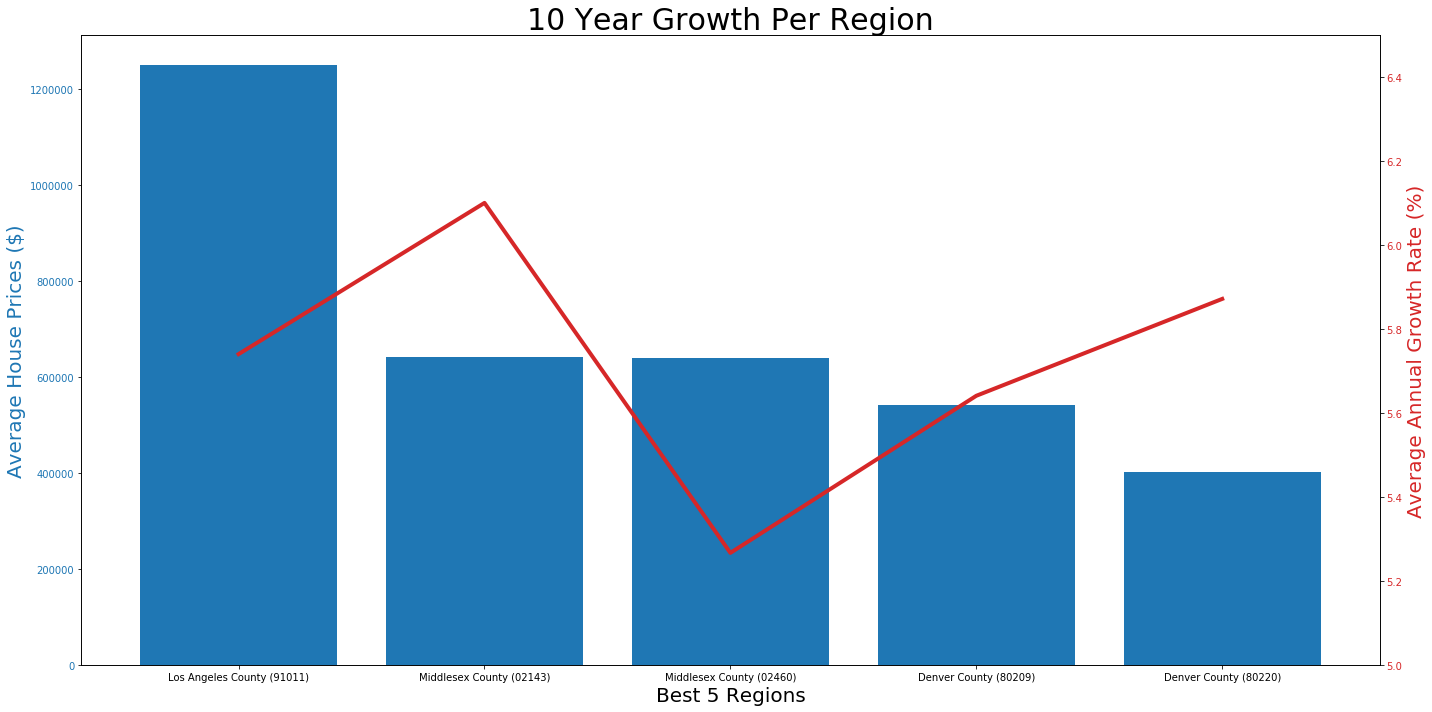

In [50]:
# Create dataframe with the necessary data for the best 5 regions
best_regions_cols = {'Region': ['Los Angeles County (91011)', 'Middlesex County (02143)', 'Middlesex County (02460)',
                                'Denver County (80209)', 'Denver County (80220)'], '10_Year_Absolute_Growth': 
     [1249665.27735994, 641670.3125, 640155.5443805, 540706.25, 401810.9375], '10_Year_Growth_Rate': 
                     [5.74043227,6.1008160,5.26675332,5.64114297,5.87203378]}
best_regions_df = pd.DataFrame(data=best_regions_cols)
 
# Initiate figure
fig, ax1 = plt.subplots(figsize=(20,10))

# Plot first y axis of absolute 10 year growth:
color = 'tab:blue'
ax1.set_xlabel('Best 5 Regions', fontsize=20)
ax1.set_ylabel('Average House Prices ($)', color=color, fontsize=20)
ax1.bar(best_regions_df['Region'], best_regions_df['10_Year_Absolute_Growth'],color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Initiate second axis that shares the same x-axis:
ax2 = ax1.twinx() 

# Plot second y axis with % growth:
color = 'tab:red'
ax2.set_ylabel('Average Annual Growth Rate (%)', color=color, fontsize=20)  # we already handled the x-label with ax1
ax2.plot(best_regions_df['Region'], best_regions_df['10_Year_Growth_Rate'], color=color, lw=4)
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim(5,6.5)

plt.title('10 Year Growth Per Region', fontsize=30)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

We see some pretty strong potential in these regions! Particularly, Los Angeles County has an estimated increase in average home value of over 1 million dollars! There also are 2 zip codes in Middlesex County with similar forecasted home values to each other, followed by 2 zip codes in Denver County.

## Step 7: Conclusion
In conclusion, the best zip codes were chosen based on the following criteria:

1. Needs to have a 5yr average annual growth rate in the top 25% of the dataset
2. Needs to also have a 10 yr average annual growth rate in the top 25% of the dataset
3. Needs a narrow predicted interval width to ensure a more accurate forecasted value (interval width must be within 50% of the smallest interval widths
4. The maximum p-value must be less than alpha=.05 to ensure we are statistically significant and therefore a better performing region.

Based on meeting these qualifications and also having the greatest forecasted return among the given sample, the 5 best zip codes to invest in are:
1. 91011 - Los Angeles County, CA
2. 02143 - Middlesex County, MA
3. 02460 - Middlesex County, MA
4. 80209 - Denver County, CO
5. 80220 - Denver County, NY


### Next Steps
I want to caveat that this analysis was done just looking at the average home values of each county over the 22 year period. There are many other factors that could play into the potential for investing in these regions (i.e. probability of severe weather, strength of school district, crime rate, age of homes, etc.). Therefore, as a next step, I would look into the impact that other variables could have on real estate investments in each of these regions.